In [1]:
import os
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing 
import math
import warnings
import operator
import re

'''
My Own Algorithms Import
'''
from preprocessing.scaler import MinMaxScaler, StandardScaler
from preprocessing.pca import PCA
from analysis.measure import ConfusionMatrix, ROC

#Ignore Warnings
warnings.filterwarnings("ignore")

#read data
salary_data = pd.read_csv('data-sets/Salary_Data.csv')
#randomize data with given seed
salary_data = salary_data.reindex(np.random.RandomState(seed=42).permutation(salary_data.index))

## Analyze the Data

In [2]:
salary_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 27 to 6
Data columns (total 2 columns):
YearsExperience    30 non-null float64
Salary             30 non-null float64
dtypes: float64(2)
memory usage: 720.0 bytes


In [3]:
salary_data.head()

,YearsExperience,Salary
27,9.6,112635.0
15,4.9,67938.0
23,8.2,113812.0
17,5.3,83088.0
8,3.2,64445.0


## Visualize Data

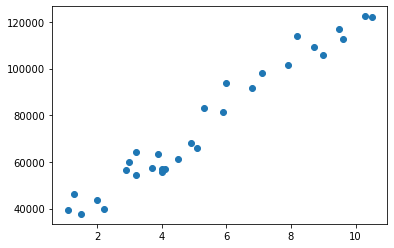

In [4]:
plt.scatter(salary_data['YearsExperience'], salary_data['Salary'])

## Set up Data

In [5]:
seventy_five__percentile = int(len(salary_data)*0.75) 
x_train, y_train = salary_data.drop(['Salary'], axis=1)[:seventy_five__percentile], salary_data['Salary'][:seventy_five__percentile]
x_test, y_test = salary_data.drop(['Salary'], axis=1)[seventy_five__percentile:], salary_data['Salary'][seventy_five__percentile:]
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

# Linear Regression

In [6]:
from random import random

class LinearRegression:
    def fit(self, x_train, y_train, alpha = 0.01, iterations = 1000):
        '''
        using gradient descent for faster calculations
        '''
        self.x_train = x_train
        self.y_train = y_train
        n = len(x_train) 
        x_matrix_df = pd.DataFrame([1 for i in range(n)], columns=['b_0 index'])
        
        for col in x_train.columns:
            x_matrix_df[col] = x_train[col]
        x_matrix = x_matrix_df.to_numpy()
        
        #Actual expensive function without gradient descent
        #b_matrix = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(x_matrix), x_matrix)), np.transpose(x_matrix)), y_train)
        self.theta = self.gradientDescent(x_matrix, y_train, [0]*(len(x_train.columns)+1), alpha=alpha, iterations=iterations)
        return self.theta
        
    def plot_regression_line(self, y_label = 'Prediction'):
        for i in range(len(self.x_train.columns)):
            plt.scatter(x_train[self.x_train.columns[i]], self.y_train, color = "m", 
               marker = "o") 
            y_pred = self.theta[0] + (self.theta[i+1]*self.x_train[self.x_train.columns[i]])
            plt.plot(self.x_train[self.x_train.columns[i]], y_pred, color = "g")
            plt.xlabel(self.x_train.columns[i]) 
            plt.ylabel(y_label) 
            plt.show()
            
    def predict(self, x_test):
        n = len(x_test) 
        x_test_matrix_df = pd.DataFrame([1 for i in range(n)], columns=['b_0 index'])
        for col in x_test.columns:
            x_test_matrix_df[col] = x_test[col]
        x_test_matrix = x_test_matrix_df.to_numpy()
        return np.dot(x_test_matrix, self.theta)
    
    def gradientDescent(self, X, y, theta, alpha, iterations):
        cost_history = [0] * iterations
        self.cost_history = []
        self.size = len(y)
        XTrans = np.transpose(X)
        new_theta = theta.copy()
        for i in range(iterations):
            old_theta = new_theta.copy()
            y_pred = np.dot(X, old_theta)
            loss = y_pred - y
            gradient = np.dot(XTrans, loss) 
            new_theta = old_theta - ((alpha/ self.size) * gradient)
            if (np.isnan(new_theta).any() or np.isinf(new_theta).any()):
                break
            cost = self.costFunction(loss, self.size)
            self.cost_history.append((cost, new_theta))
        return min(self.cost_history, key = lambda t: t[0])[1]

    def plotCostPerIteration(self):
        costs = [c[0] for c in self.cost_history]
        plt.plot(np.arange(len(self.cost_history)), costs)
        plt.xlabel("iterations") 
        plt.ylabel("cost") 
        plt.show()
        
    def costFunction(self, loss, m):
        J = np.sum((loss) ** 2)/(2 * m)
        return J

In [7]:
linearRegression = LinearRegression()
linearRegression.fit(x_train, y_train.values, alpha = 0.05)

array([25141.85087878,  9508.0568207 ])

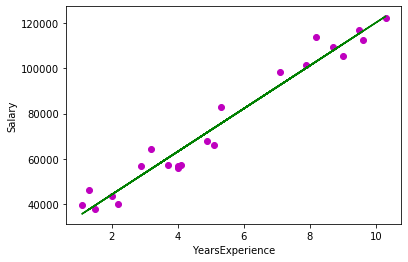

In [8]:
linearRegression.plot_regression_line('Salary')

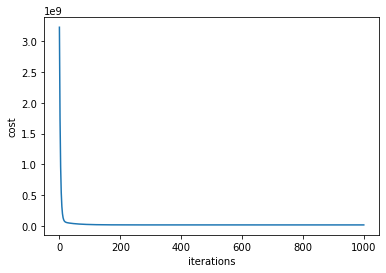

In [9]:
linearRegression.plotCostPerIteration()

## Test Implementation

In [10]:
predictions = linearRegression.predict(x_test)
predictions

array([ 81239.38612092, 124976.44749615,  89796.63725956,  55567.63270503,
        62223.27247952,  67928.10657194,  82190.19180299,  53666.02134089])

## Cost function

In [11]:
def costFunction(predictions, results):
    residual_error = results-predictions
    return sum([e**2 for e in residual_error])/(2*(len(predictions)))

In [12]:
costFunction(predictions, y_test.values)

15140279.056205802

## Compare with sklearn

In [13]:
from sklearn.linear_model import LinearRegression as skLinearRegression
reg = skLinearRegression()
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
skpredictions = reg.predict(x_test)
skpredictions

array([ 81239.41094385, 124976.35372677,  89796.63887964,  55567.72713648,
        62223.34886432,  67928.16748818,  82190.21404783,  53666.12092853])

In [15]:
costFunction(skpredictions, y_test.values)

15140184.169832379

# Linear Regression with multiple features

## Predict Startup Profit

In [16]:
#read data
startup_data = pd.read_csv('data-sets/50_Startups.csv')
#randomize data with given seed
startup_data = startup_data.reindex(np.random.RandomState(seed=42).permutation(startup_data.index))

## Analyze the data

In [17]:
startup_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 13 to 38
Data columns (total 5 columns):
R&D Spend          50 non-null float64
Administration     50 non-null float64
Marketing Spend    50 non-null float64
State              50 non-null object
Profit             50 non-null float64
dtypes: float64(4), object(1)
memory usage: 2.3+ KB


In [18]:
startup_data.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
13,91992.39,135495.07,252664.93,California,134307.35
39,38558.51,82982.09,174999.30,California,81005.76
30,61994.48,115641.28,91131.24,Florida,99937.59
45,1000.23,124153.04,1903.93,New York,64926.08
17,94657.16,145077.58,282574.31,New York,125370.37


## Visualize Data

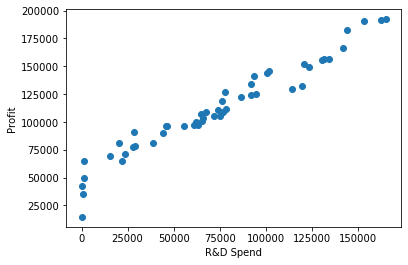

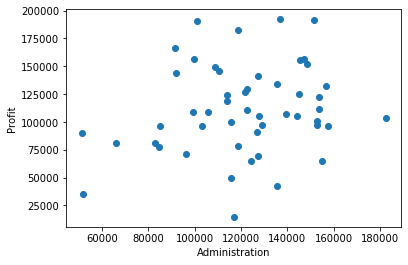

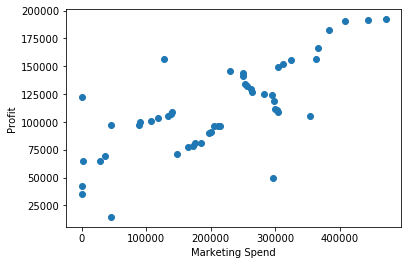

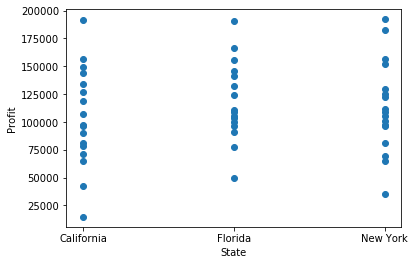

In [19]:
def scatterTable(x_train, y, y_label):
    for column in x_train.columns:
        plt.scatter(x_train[column], y, marker = "o") 
        plt.xlabel(column) 
        plt.ylabel(y_label) 
        plt.show()
        
profit_column = startup_data['Profit'].values
other_columns = startup_data.drop(['Profit'], axis = 1)
scatterTable(other_columns, profit_column, 'Profit')

## Set up data

In [20]:
startup_data = startup_data.drop(['State'], axis = 1)

In [21]:
seventy_five__percentile = int(len(startup_data)*0.75) 
x_train, y_train = startup_data.drop(['Profit'], axis=1)[:seventy_five__percentile], startup_data['Profit'][:seventy_five__percentile]
x_test, y_test = startup_data.drop(['Profit'], axis=1)[seventy_five__percentile:], startup_data['Profit'][seventy_five__percentile:]
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

In [22]:
linearRegression = LinearRegression()
linearRegression.fit(x_train, y_train.values, alpha = 0.07)

array([8.05741024e+03, 7.51475535e+08, 9.99117481e+08, 1.95630121e+09])

In [23]:
predictions = linearRegression.predict(x_test)

In [24]:
costFunction(predictions, y_test.values)

1.9844592209486846e+29

## Find best learning rate

In [25]:
learning_rates = [0.0000000000001, 0.00000000000012, 0.00000000000014, 0.00000000000016, 0.00000000000018]
lr_cost_functions = []
for lr in learning_rates:
    linearRegression.fit(x_train, y_train.values, alpha = lr)
    predictions = linearRegression.predict(x_test)
    cost = costFunction(predictions, y_test.values)
    lr_cost_functions.append((lr, cost))

best_learning_rate = min(lr_cost_functions, key = lambda t: t[1])[0]
print("Learning rate: " + str(best_learning_rate))

Learning rate: 1.6e-13


In [26]:
linearRegression.fit(x_train, y_train.values, alpha = best_learning_rate)

array([2.48347435e-06, 2.20278860e-01, 3.05565231e-01, 2.68097429e-01])

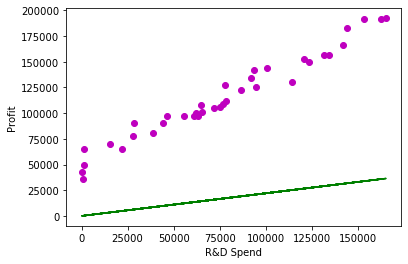

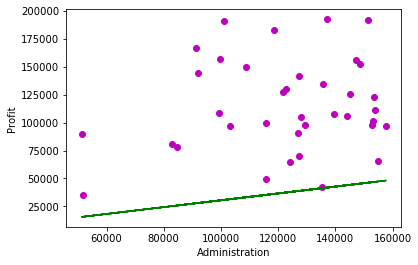

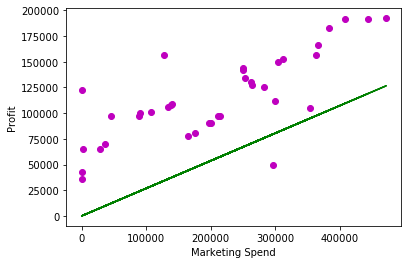

In [27]:
linearRegression.plot_regression_line('Profit')

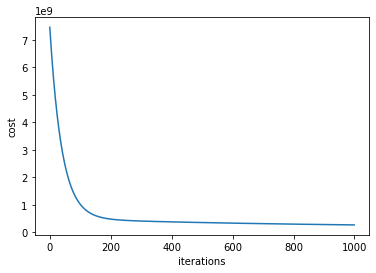

In [28]:
linearRegression.plotCostPerIteration()

In [29]:
predictions = linearRegression.predict(x_test)

In [30]:
costFunction(predictions, y_test.values)

135675025.59270576

## Compare with sklearn

In [31]:
reg = skLinearRegression()
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
skpredictions = reg.predict(x_test)
skpredictions

array([ 89654.78415453, 109894.02715908,  75998.78028454, 135337.66580877,
       115444.80406273, 129087.47708776,  49788.11828987, 116876.27332202,
       161292.58276188,  70687.9377109 , 151605.17186022, 105903.06666229,
        68140.90766027])

In [33]:
costFunction(skpredictions, y_test.values)

77848636.6975258